# Heart disease prediction

## Purpose

The purpose of the project is to określić the ratio of patients who have good chance of being affected by cardiovascular disease (CVD).

Two methods will be used: logistic regression and random forrest. At the end accuracy for both of them will be calculated and compared.

## EDA

In [3]:
# Libraries
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
import statsmodels.api as sm
from sklearn import preprocessing
'exec(% matplotlib inline)'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sn

In [4]:
# Dataset
disease_df = pd.read_csv("C:/Users/qbalo/Desktop/Projekty/regresja logistyczna/Logistic_regression/framingham.csv")
disease_df.drop(['education'], inplace = True, axis = 1)
disease_df.rename(columns ={'male':'Sex_male'}, inplace = True)
disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Sex_male         4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   currentSmoker    4240 non-null   int64  
 3   cigsPerDay       4211 non-null   float64
 4   BPMeds           4187 non-null   float64
 5   prevalentStroke  4240 non-null   int64  
 6   prevalentHyp     4240 non-null   int64  
 7   diabetes         4240 non-null   int64  
 8   totChol          4190 non-null   float64
 9   sysBP            4240 non-null   float64
 10  diaBP            4240 non-null   float64
 11  BMI              4221 non-null   float64
 12  heartRate        4239 non-null   float64
 13  glucose          3852 non-null   float64
 14  TenYearCHD       4240 non-null   int64  
dtypes: float64(8), int64(7)
memory usage: 497.0 KB


In [35]:
# removing NaN / NULL values
disease_df.dropna(axis = 0, inplace = True)
#print(disease_df.head(), disease_df.shape)
#print(disease_df.TenYearCHD.value_counts())
display(disease_df.head(10))

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0
6,0,63,0,0.0,0.0,0,0,0,205.0,138.0,71.0,33.11,60.0,85.0,1
7,0,45,1,20.0,0.0,0,0,0,313.0,100.0,71.0,21.68,79.0,78.0,0
8,1,52,0,0.0,0.0,0,1,0,260.0,141.5,89.0,26.36,76.0,79.0,0
9,1,43,1,30.0,0.0,0,1,0,225.0,162.0,107.0,23.61,93.0,88.0,0


In [66]:
summary = {
    'Number of males': (disease_df['Sex_male'] == 1).sum(),
    'Number of females': (disease_df['Sex_male'] == 0).sum(),
    'Number of smokers': (disease_df['currentSmoker'] == 1).sum(),
    'Number of non-smokers': (disease_df['currentSmoker'] == 0).sum(),
    'Number of patients with heart disease': disease_df['TenYearCHD'].sum(),
    'Number of patients without heart disease': (disease_df['TenYearCHD']==0).sum()
}

# Convert the summary dictionary to a DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['Count'])

print(summary_df)

                                          Count
Number of males                            1670
Number of females                          2081
Number of smokers                          1832
Number of non-smokers                      1919
Number of patients with heart disease       572
Number of patients without heart disease   3179


(array([22.19141562,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 17.80858438]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   ]),
 [<matplotlib.patches.Polygon at 0x118fb850080>])

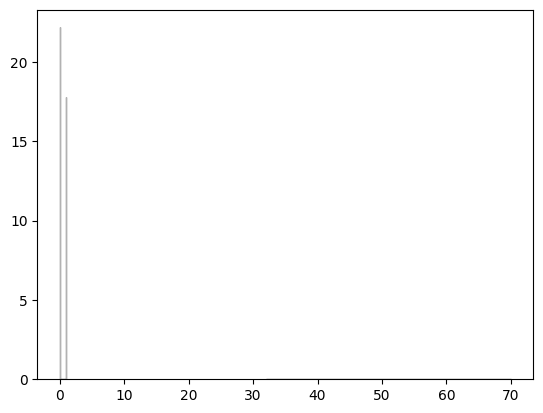

In [46]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40, ec="k")
plt.hist(disease_df['age'], **kwargs)

C:\Users\qbalo\AppData\Local\Temp\ipykernel_12064\453444664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x='Sex_male', data=disease_df,


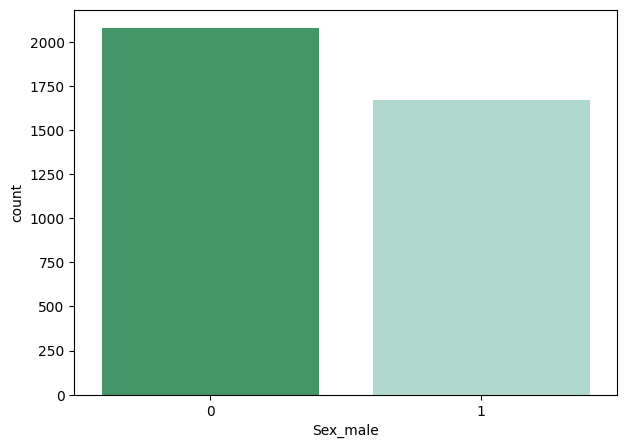

In [49]:
plt.figure(figsize=(7, 5))
sn.countplot(x='Sex_male', data=disease_df,
             palette="BuGn_r")
plt.show()

C:\Users\qbalo\AppData\Local\Temp\ipykernel_12064\3044778646.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x='currentSmoker', data=disease_df,


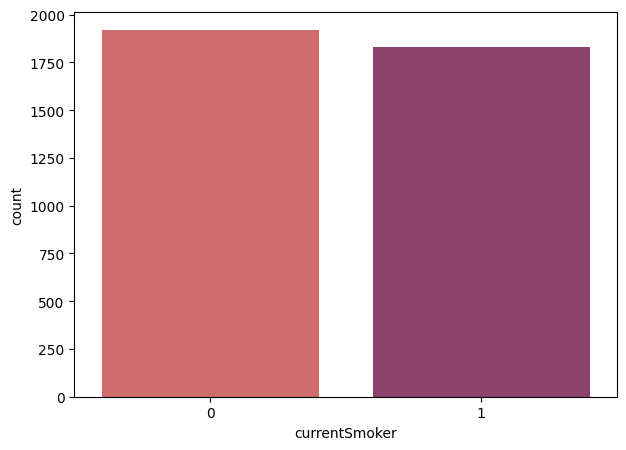

In [53]:
plt.figure(figsize=(7, 5))
sn.countplot(x='currentSmoker', data=disease_df,
             palette="flare")
plt.show()

(array([3.01938531e-01, 1.53863732e-02, 1.70621168e-02, 2.58978558e-03,
        3.04680657e-03, 3.47335949e-02, 1.21872263e-03, 4.57020985e-04,
        2.86399817e-02, 1.52340328e-03, 1.37106295e-03, 1.01153978e-01,
        0.00000000e+00, 9.14041970e-04, 7.31233576e-03, 0.00000000e+00,
        1.52340328e-04, 2.98587043e-02, 0.00000000e+00, 0.00000000e+00,
        2.89446624e-03, 1.52340328e-04, 1.08161633e-02, 0.00000000e+00,
        7.46467609e-03, 4.57020985e-04, 0.00000000e+00, 0.00000000e+00,
        6.09361313e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.52340328e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.52340328e-04]),
 array([ 0.  ,  1.75,  3.5 ,  5.25,  7.  ,  8.75, 10.5 , 12.25, 14.  ,
        15.75, 17.5 , 19.25, 21.  , 22.75, 24.5 , 26.25, 28.  , 29.75,
        31.5 , 33.25, 35.  , 36.75, 38.5 , 40.25, 42.  , 43.75, 45.5 ,
        47.25, 49.  , 50.75, 52.5 , 54.25, 56.  , 57.75, 59.5 , 6

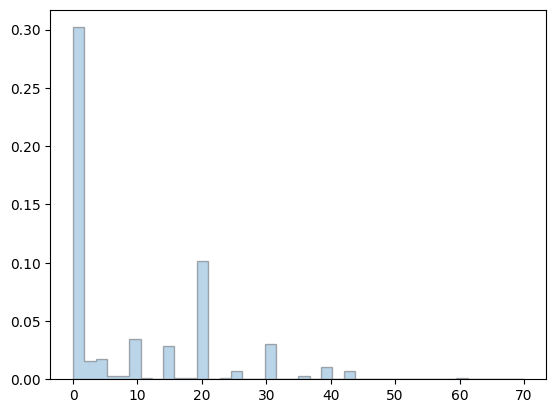

In [59]:
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40, ec="k")
plt.hist(disease_df['cigsPerDay'], **kwargs)

C:\Users\qbalo\AppData\Local\Temp\ipykernel_12064\1041904023.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x='BPMeds', data=disease_df,


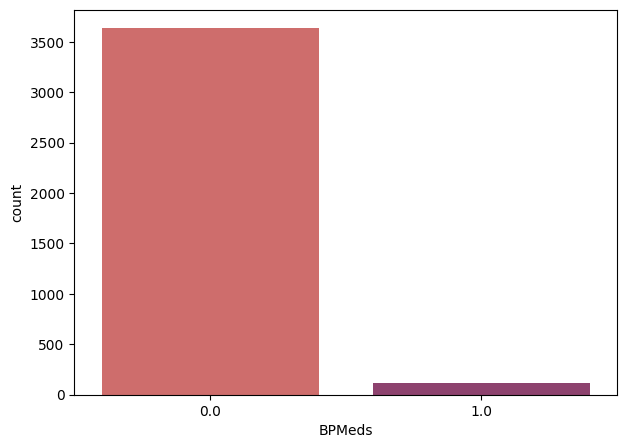

In [60]:
plt.figure(figsize=(7, 5))
sn.countplot(x='BPMeds', data=disease_df,
             palette="flare")
plt.show()

C:\Users\qbalo\AppData\Local\Temp\ipykernel_12064\2760816052.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x='TenYearCHD', data=disease_df,


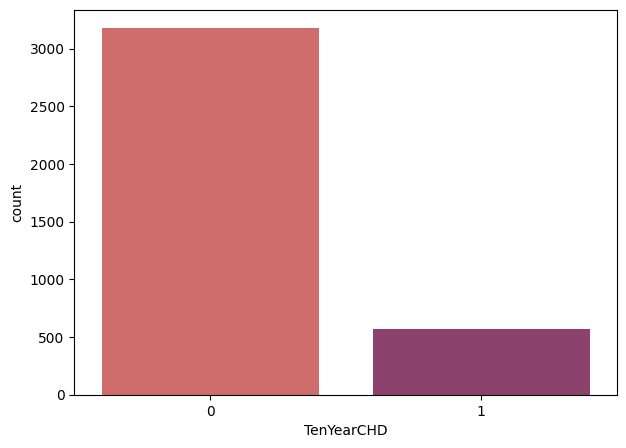

In [62]:
plt.figure(figsize=(7, 5))
sn.countplot(x='TenYearCHD', data=disease_df,
             palette="flare")
plt.show()

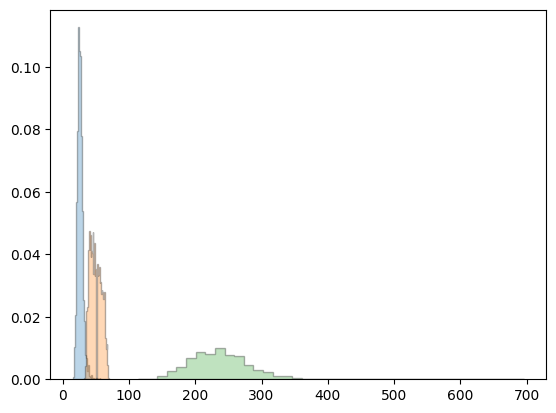

In [40]:
plt.hist(disease_df['BMI'], **kwargs)
plt.hist(disease_df['age'], **kwargs)
plt.hist(disease_df['totChol'], **kwargs);

plt.show()

C:\Users\qbalo\AppData\Local\Temp\ipykernel_12064\732448823.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sn.countplot(x='TenYearCHD', data=disease_df,


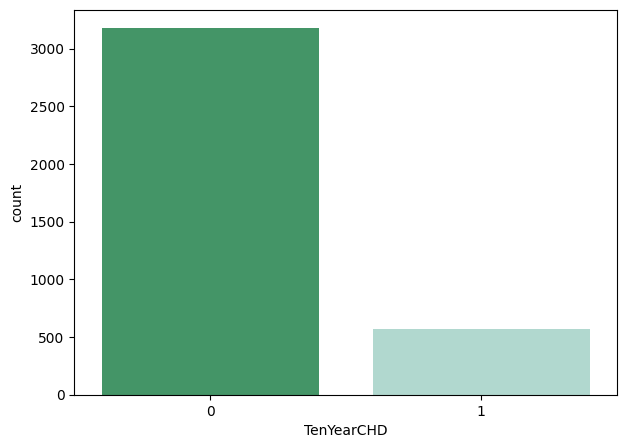

In [39]:
# counting no. of patients affected with CHD
plt.figure(figsize=(7, 5))
sn.countplot(x='TenYearCHD', data=disease_df,
             palette="BuGn_r")
plt.show()

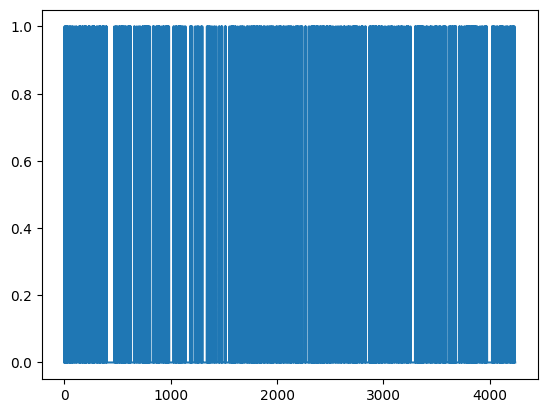

In [7]:
laste = disease_df['TenYearCHD'].plot()
plt.show(laste)

## Splitting data & normalization

In [8]:
X = np.asarray(disease_df[['age', 'Sex_male', 'cigsPerDay', 
                           'totChol', 'sysBP', 'glucose']])
y = np.asarray(disease_df['TenYearCHD'])
 
# normalization of the dataset
X = preprocessing.StandardScaler().fit(X).transform(X)
 
# Train-and-Test -Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( 
        X, y, test_size = 0.3, random_state = 4)
 
 
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2625, 6) (2625,)
Test set: (1126, 6) (1126,)


## Models

### Logistic regression

Logistic regression is a supervised machine learning algorithm used for classification tasks where **the goal is to predict the probability** that an instance belongs to a given class or not. It predicts the output of a categorical dependent variable. To map the predicted values (within a range of 0 and 1) to probabilities, the sigmoid function is used.

Types of logical regression:
* binomal - there can be only two possible types of the dependent variables, such as 0 or 1, Pass or Fail
* multinomial - can be 3 or more possible unordered types of the dependent variable, such as “cat”, “dogs”, or “sheep”
* ordinal - can be 3 or more possible ordered types of dependent variables, such as “Low”, “Medium”, or “High”

**Odds** the ratio of something occurring to something not occurring. it is different from probability as the probability is the ratio of something occurring to everything that could possibly occur
**Log-odds** or the **logit function**, is the natural logarithm of the odds. In logistic regression, the log odds of the dependent variable are modeled as a linear combination of the independent variables and the intercept.


In [9]:
from sklearn.linear_model import LogisticRegression
 
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
 

### Random forrest

Random Forest is a type of supervised learning algorithm that can be used for both classification and regression tasks. A random forest is an ensemble learning method that combines the predictions from multiple decision trees to produce a more accurate and stable prediction.
Ensemble learning combines the predictions from multiple models, it is an approach that leverages the collective intelligence of multiple models.
Types of ensemble methods:
- **bagging** (bootstrap aggregating), involves training multiple models on random subsets of the training data. The predictions from the individual models are then combined, typically by averaging,
- **boosting** involves training a sequence of models, where each subsequent model focuses on the errors made by the previous model. The predictions are combined using a weighted voting scheme,
- **stacking** involves using the predictions from one set of models as input features for another model. The final prediction is made by the second-level model.

Every decision tree has high variance, but after combining all of them in parallel then the resultant variance is low as each decision tree gets perfectly trained on that particular sample data, and hence the output doesn’t depend on one decision tree but on multiple decision trees. In the case of a classification problem, the final output is taken by using the **majority voting classifier**. In the case of a regression problem, the final output is the mean of all the outputs. This part is called **Aggregation**.

The part where random row sampling and feature sampling is performed is called **bootstrap**. 

In random forrest out-of-bag (OOB) score is used to evaluate the performance of the model. OOB is the type of validation technique that is mainly used in bagging algorithms to validate the bagging algorithm. Here a small part of the validation data is taken from the mainstream of the data and the predictions on the particular validation data are done and compared with the other results.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor 

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X_train, y_train)
 

c:\Users\qbalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [31]:
X_grid = np.arange(X_test.min(),X_test.max(),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 
X_grid
   
#plt.scatter(X_test,y_test, color='blue') #plotting real points
#plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points
   


array([[-2.32992966],
       [-2.31992966],
       [-2.30992966],
       ...,
       [13.05007034],
       [13.06007034],
       [13.07007034]])

ValueError: x and y must be the same size

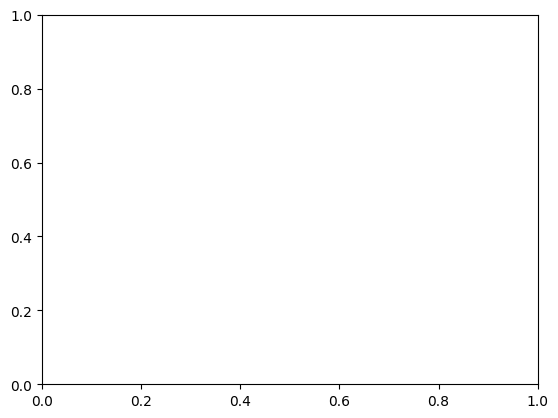

In [26]:
import numpy as np
X_grid = np.arange(X_test.min(),X_test.max(),0.01)
X_grid = X_grid.reshape(len(X_grid),1) 
   
plt.scatter(X_test,y_test, color='blue') #plotting real points
plt.plot(X_grid, regressor.predict(X_grid),color='green') #plotting for predict points
   
plt.title("Random Forest Regression Results")
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

In [18]:
# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(X_train)
 
# Evaluating the model
mse = mean_squared_error(y_train, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_train, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: -0.24951331352116513
Mean Squared Error: 0.023200000000000002
R-squared: 0.8192655644442837


## Model evaluation

Logistic regression can be evaluated suing following metrics:
- accuracy - the proportion of correctly classified instances $\frac{true positives + true negatives}{total}$
- precision - the accuracy of positive predictions $\frac{true positives}{true positives + false positives}$
- recall - the proportion of correctly predicted positive instances among all actual positive instances
- F1 score - the harmonic mean of precision and recall
- Area under the receiver operating characteristic curve (AUC-ROC) - The ROC curve plots the true positive rate against the false positive rate at various thresholds. AUC-ROC measures the area under this curve, providing an aggregate measure of a model’s performance across different classification thresholds.
- Area under the precision-recall curve (AUC-PR) - measures the area under the precision-recall curve, providing a summary of a model’s performance across different precision-recall trade-offs.

**Cost function** https://www.geeksforgeeks.org/ml-cost-function-in-logistic-regression/

### Evaluation and accuracy of logistic regression and random forrest


In [11]:
from sklearn.metrics import jaccard_score
 
print('')
print('Accuracy of the model in jaccard similarity score is = ', 
      jaccard_score(y_test, y_pred))
score = rf.score(X_test,y_test)*100
print('Accuracy of the random forrest is = ', score)



Accuracy of the model in jaccard similarity score is =  0.07608695652173914
Accuracy of the random forrest is =  84.01420959147424


### Confusion matrix for random forrest model

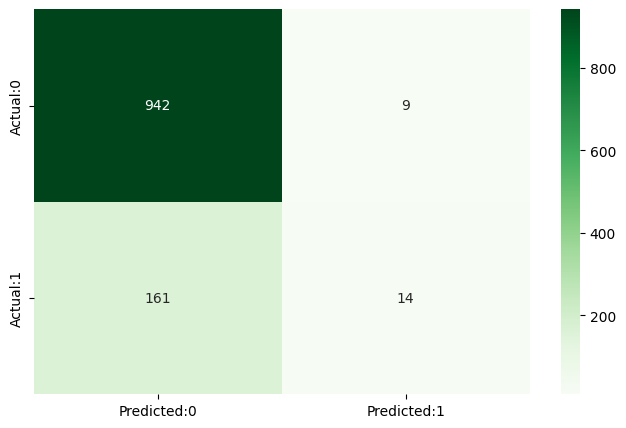

The details for confusion matrix is =
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       951
           1       0.61      0.08      0.14       175

    accuracy                           0.85      1126
   macro avg       0.73      0.54      0.53      1126
weighted avg       0.82      0.85      0.80      1126



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
 
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data = cm, 
                           columns = ['Predicted:0', 'Predicted:1'], 
                           index =['Actual:0', 'Actual:1'])
 
plt.figure(figsize = (8, 5))
sn.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "Greens")
 
plt.show()
 
print('The details for confusion matrix is =')
print (classification_report(y_test, y_pred))